<a href="https://colab.research.google.com/github/LohitSubodh/Edgistify/blob/master/lab_3b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 3 (b)**
### Weightage 3.6%
# Convolutional Neural Networks
---
Dataset used: Cats Vs. Dogs

---



Maximum Points in the Lab: 90

---
Important points to remember :


1.  Observations for the experiments should be explained.
2. All the code should be submitted in the form of a single Jupyter notebook itself.
3. Points for each sub-section are mentioned in the appropriate question.
4. Make sure to begin early as a few experiments may consume more time to run.
5. You can use Google colab to run in jupyter notebook (https://colab.research.google.com/) How to load data in Google Colab ?(https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92)
6. The lab must be submitted on Google classroom. The code as well as the accompanying observations should be made part of the python notebook.
7. **Code Readability** is very important. Hence use self explanatory variable names and add comments to describe your approach wherever necessary.
8. You are expected to submit your **detailed inferences** and not just an error free code.
9. The lab is due on **March 20th 11.59pm**.
10. The lab should be completed **individually**. Students are expected to follow the **honor code** of the class.




In this part of your Lab 3, you will be using Convolutional Neural Network to classify whether a given image contains a Cat or a Dog. You can use the tensorflow package for this implementation. The Cats and Dogs dataset from the famous Kaggle contest which is filtered and available at tensorflow can be used.

In [0]:
# Import the necessary libraries

import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import shutil
import random
from sklearn.metrics import confusion_matrix

# If using Google Colab, use the following package to display the image
# If running on your local system, cv2.imshow shall work fine
# If running on your local system please comment the line below
from google.colab.patches import cv2_imshow

# Data loading and Preprocessing

---


The following blocks downloads the dataset stored at tensorflow and extracts them to be used to train the CNN model. **Please don't make any changes to these blocks below.**

In [0]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract = True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68608000/68606236 [==============================] - 2s 0us/step


The dataset has the following directory structure:

<pre>
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

Extract the paths of these directories onto different variables to facilitate accessing the dataset and thereby training the model.

In [0]:
train_dir_path = os.path.join(PATH, 'train')
validation_dir_path = os.path.join(PATH, 'validation')

train_cats_dir_path = os.path.join(train_dir_path, 'cats')  
train_dogs_dir_path = os.path.join(train_dir_path, 'dogs') 
validation_cats_dir_path = os.path.join(validation_dir_path, 'cats')  
validation_dogs_dir_path = os.path.join(validation_dir_path, 'dogs')  

## Create a labelled test set from the validation set
As you would have seen we have only training and validation sets with labels as the ground truth labels for the Kaggle contest test set images is not public. Hence we shall consider 10% of validation data (5% Cats, 5% Dogs)  as our test set. 


In [0]:
# Create a test directory with the same Cats and Dogs sub directory structure 
test_dir_path = os.path.join(PATH, 'labelled_test')
if not  os.path.exists(test_dir_path):
    os.makedirs(test_dir_path)
test_cats_dir_path = os.path.join(test_dir_path,'cats')
test_dogs_dir_path = os.path.join(test_dir_path,'dogs')
if not os.path.exists(test_cats_dir_path):
    os.makedirs(test_cats_dir_path)
if not os.path.exists(test_dogs_dir_path):
    os.makedirs(test_dogs_dir_path)

# Randomly pick 5% of validation Cat Images 
val_cat_list = os.listdir(validation_cats_dir_path)
num_cat_test_files = int(0.05 * len(val_cat_list))
chosen_cats = random.sample(val_cat_list,num_cat_test_files)

# Randomly pick 5% of validation Dog Images 
val_dog_list = os.listdir(validation_dogs_dir_path)
num_dog_test_files = int(0.05 * len(val_dog_list))
chosen_dogs = random.sample(val_dog_list,num_dog_test_files)

# Move the selected Cat Images from Validation Cats directory to Test Cats directory 
for cat in chosen_cats:
    src_path = os.path.join(validation_cats_dir_path,cat)
    if not os.path.exists(os.path.join(test_cats_dir_path,cat)):
        shutil.move(src_path,test_cats_dir_path)

# Move the selected Dog Images from Validation Dogs directory to Test Dogs directory 
for dog in chosen_dogs:
    src_path = os.path.join(validation_dogs_dir_path,dog)
    if not os.path.exists(os.path.join(test_dogs_dir_path,dog)):
        shutil.move(src_path,test_dogs_dir_path)  


In [0]:
num_cats_train =  len(os.listdir(train_cats_dir_path))
num_dogs_train =  len(os.listdir(train_dogs_dir_path))
num_cats_val =  len(os.listdir(validation_cats_dir_path))
num_dogs_val =  len(os.listdir(validation_dogs_dir_path))
num_cats_test =  len(os.listdir(test_cats_dir_path))
num_dogs_test =  len(os.listdir(test_dogs_dir_path))

total_train_data = num_cats_train + num_dogs_train
total_val_data = num_cats_val + num_dogs_val
total_test_data = num_cats_test + num_dogs_test

The images are of different sizes, but our machine learning model requires input images to be of a fixed size. Let us decide an input size 200 x 200.

In [0]:
IMG_HEIGHT = 200
IMG_WIDTH = 200

# Generate Image Batches


---


As images are high dimensional, fitting the model on entire training set may be memory and computation inefficient. Hence we generate batches of images to be processed by the model. `ImageDataGenerator` class in tensorflow facilitates this. 

Describe the various arguments in the instantiation of `tensorflow.keras.preprocessing.image.ImageDataGenerator` object.


---

**5 Points**

---




**Arguments**



*   **featurewise_center**: Boolean. Set input mean to 0 over the dataset, feature-wise.

*   **samplewise_center**: Boolean. Set each sample mean to 0.


*   **featurewise_std_normalization**: Boolean. Divide inputs by std of the dataset, feature-wise
*   **samplewise_std_normalization**: Boolean. Divide each input by its std.


*   **zca_epsilon** : epsilon for ZCA whitening. Default is 1e-6

*   **zca_whitening**: Boolean. Apply ZCA whitening


*   **rotation_range**: Int. Degree range for random rotations

*   **width_shift_range** :Float, 1-D array-like or int

float: fraction of total width, if < 1, or pixels if >= 1.

1-D array-like: random elements from the array.

int: integer number of pixels from interval (-width_shift_range, +width_shift_range)

With width_shift_range=2 possible values are integers [-1, 0, +1], same as with width_shift_range=[-1, 0, +1]
* **height_shift_range**: Float, 1-D array-like or int

float: fraction of total height, if < 1, or pixels if >= 1.

1-D array-like: random elements from the array.

int: integer number of pixels from interval (-height_shift_range, +height_shift_range)

With height_shift_range=2 possible values are integers [-1, 0, +1], same as with height_shift_range=[-1, 0, +1]
* **brightness_range**: Tuple or list of two floats. Range for picking a brightness shift value from.
* **shear_range**: Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
* **zoom_range**: Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range].
* **channel_shift_range**: Float. Range for random channel shifts.
* **fill_mode**: One of {"constant", "nearest", "reflect" or "wrap"}. Default is 'nearest'. Points outside the boundaries of the input are filled according to the given mode:

'constant', 
'nearest',
'reflect',
'wrap'
* **cval**: Float or Int. Value used for points outside the boundaries when fill_mode = "constant".
* **horizontal_flip**: Boolean. Randomly flip inputs horizontally.
* **vertical_flip**: Boolean. Randomly flip inputs vertically.
* **rescale**: rescaling factor. Defaults to None. If None or 0, no rescaling is applied, otherwise we multiply the data by the value provided (after applying all other transformations).
* **preprocessing_function**: function that will be applied on each input. The function will run after the image is resized and augmented. The function should take one argument: one image (Numpy tensor with rank 3), and should output a Numpy tensor with the same shape.
* **data_format**: Image data format, either "channels_first" or "channels_last". "channels_last" mode means that the images should have shape (samples, height, width, channels), "channels_first" mode means that the images should have shape (samples, channels, height, width). It defaults to the image_data_format value found in your Keras config file at ~/.keras/keras.json.
* **validation_split**: Float. Fraction of images reserved for validation (strictly between 0 and 1).
* **dtype**: Dtype to use for the generated arrays.











Describe the arguments of `flow_from_directory()` method of the `tensorflow.keras.preprocessing.image.ImageDataGenerator` object. 

---

**5 Points**

---

**Arguments**

* **directory**: string, path to the target directory.
    It should contain one subdirectory per class.
    Any PNG, JPG, BMP, PPM or TIF images
    inside each of the subdirectories directory tree
    will be included in the generator.
   
* **target_size**: Tuple of integers `(height, width)`,
    default: `(256, 256)`.
    The dimensions to which all images found will be resized.
* **color_mode**: One of "grayscale", "rgb", "rgba". Default: "rgb".
    Whether the images will be converted to
    have 1, 3, or 4 channels.
* **classes**: Optional list of class subdirectories
    (e.g. `['dogs', 'cats']`). Default: None.
    If not provided, the list of classes will be automatically
    inferred from the subdirectory names/structure
    under `directory`, where each subdirectory will
    be treated as a different class
    (and the order of the classes, which will map to the label
    indices, will be alphanumeric).
    The dictionary containing the mapping from class names to class
    indices can be obtained via the attribute `class_indices`.
* **class_mode**: One of "categorical", "binary", "sparse",
    "input", or None. Default: "categorical".
    Determines the type of label arrays that are returned:
    - "categorical" will be 2D one-hot encoded labels,
    - "binary" will be 1D binary labels,
        "sparse" will be 1D integer labels,
    - "input" will be images identical
        to input images (mainly used to work with autoencoders).
    - If None, no labels are returned
      (the generator will only yield batches of image data,
      which is useful to use with `model.predict_generator()`).
    
* **batch_size**: Size of the batches of data (default: 32).
* **shuffle**: Whether to shuffle the data (default: True)
    If set to False, sorts the data in alphanumeric order.
* **seed**: Optional random seed for shuffling and transformations.
* **save_to_dir**: None or str (default: None).
    This allows you to optionally specify
    a directory to which to save
    the augmented pictures being generated
    (useful for visualizing what you are doing).
* **save_prefix**: Str. Prefix to use for filenames of saved pictures
    (only relevant if `save_to_dir` is set).
* **save_format**: One of "png", "jpeg"
    (only relevant if `save_to_dir` is set). Default: "png".
* **follow_links**: Whether to follow symlinks inside
    class subdirectories (default: False).
* **subset**: Subset of data (`"training"` or `"validation"`) if
    `validation_split` is set in `ImageDataGenerator`.
* **interpolation**: Interpolation method used to
    resample the image if the
    target size is different from that of the loaded image.
    By default, `"nearest"` is used.

Create a function that returns a generator object which shall fetch batches of images from the specified directory. This function shall be reused for fetching images from train, validation or test directories.



---

**5 Points**


---




In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def get_generator(directory_path, batch_size_):
    # Insert your code here
    train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
    data_batch_generator = train_datagen.flow_from_directory(
    directory_path,
    target_size=(200, 200),
    batch_size=batch_size_,
    class_mode='binary')



    return data_batch_generator

Describe the arguments for the following functions callable on a `tensorflow.keras.Sequential` model object :

1. add() **[5 Points]**

* **layer**: layer instance.

2. compile() **[5 Points]**

* **optimizer**: String (name of optimizer) or optimizer instance.
* **loss**: String (name of objective function), objective function or tf.keras.losses.Loss instance. An objective function is any callable with the signature scalar_loss = fn(y_true, y_pred). If the model has multiple outputs, you can use a different loss on each output by passing a dictionary or a list of losses. The loss value that will be minimized by the model will then be the sum of all individual losses.
* **metrics**: List of metrics to be evaluated by the model during training and testing. Typically you will use metrics=['accuracy']. To specify different metrics for different outputs of a multi-output model, you could also pass a dictionary, such as metrics={'output_a': 'accuracy', 'output_b': ['accuracy', 'mse']}.
* **loss_weights**: Optional list or dictionary specifying scalar coefficients (Python floats) to weight the loss contributions of different model outputs. The loss value that will be minimized by the model will then be the weighted sum of all individual losses, weighted by the loss_weights coefficients. If a list, it is expected to have a 1:1 mapping to the model's outputs. 
* **sample_weight_mode**: If you need to do timestep-wise sample weighting (2D weights), set this to "temporal". None defaults to sample-wise weights (1D). If the model has multiple outputs, you can use a different sample_weight_mode on each output by passing a dictionary or a list of modes.
* **weighted_metrics**: List of metrics to be evaluated and weighted by sample_weight or class_weight during training and testing.
* **target_tensors**: By default, Keras will create placeholders for the model's target, which will be fed with the target data during training. If instead you would like to use your own target tensors, you can specify them via the target_tensors argument. It can be a single tensor (for a single-output model), a list of tensors, or a dict mapping output names to target tensors.
* **distribute**: NOT SUPPORTED IN TF 2.0, please create and compile the model under distribution strategy scope instead of passing it to compile.
* **kwargs**: Any additional arguments.

3. fit() **[5 Points]**

* **x**: Input data. It could be:
A Numpy array (or array-like), or a list of arrays (in case the model has multiple inputs).

A TensorFlow tensor, or a list of tensors (in case the model has multiple inputs).

A dict mapping input names to the corresponding array/tensors, if the model has named inputs.

A tf.data dataset. Should return a tuple of either (inputs, targets) or (inputs, targets, sample_weights).

A generator or keras.utils.Sequence returning (inputs, targets) or (inputs, targets, sample weights).
* **y**: Target data. Like the input data x, it could be either Numpy array(s) or TensorFlow tensor(s). It should be consistent with x (you cannot have Numpy inputs and tensor targets, or inversely). If x is a dataset, generator, or keras.utils.Sequence instance, y should not be specified (since targets will be obtained from x).
* **batch_size**: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32. Do not specify the batch_size if your data is in the form of symbolic tensors, datasets, generators, or keras.utils.Sequence instances (since they generate batches).
* **epochs**: Integer. Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided. Note that in conjunction with initial_epoch, epochs is to be understood as "final epoch". The model is not trained for a number of iterations given by epochs, but merely until the epoch of index epochs is reached.
* **verbose**: 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. Note that the progress bar is not particularly useful when logged to a file, so verbose=2 is recommended when not running interactively (eg, in a production environment).
* **callbacks**: List of keras.callbacks.Callback instances. List of callbacks to apply during training. 
* **validation_split**: Float between 0 and 1. Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. The validation data is selected from the last samples in the x and y data provided, before shuffling.
* **validation_data**: Data on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data. validation_data will override validation_split. validation_data could be:
tuple (x_val, y_val) of Numpy arrays or tensors

tuple (x_val, y_val, val_sample_weights) of Numpy arrays

dataset For the first two cases, batch_size must be provided. For the last case, validation_steps could be provided.
* **shuffle**: Boolean (whether to shuffle the training data before each epoch) or str (for 'batch'). 'batch' is a special option for dealing with the limitations of HDF5 data; it shuffles in batch-sized chunks. Has no effect when steps_per_epoch is not None.
* **class_weight**: Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.
* **sample_weight**: Optional Numpy array of weights for the training samples, used for weighting the loss function (during training only). You can either pass a flat (1D) Numpy array with the same length as the input samples (1:1 mapping between weights and samples), or in the case of temporal data, you can pass a 2D array with shape (samples, sequence_length), to apply a different weight to every timestep of every sample. 
* **initial_epoch**: Integer. Epoch at which to start training (useful for resuming a previous training run).
* **steps_per_epoch**: Integer or None. Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined. 
* **validation_steps**: Only relevant if validation_data is provided and is a tf.data dataset. Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch. If 'validation_steps' is None, validation will run until the validation_data dataset is exhausted. In the case of a infinite dataset, it will run into a infinite loop. If 'validation_steps' is specified and only part of the dataset will be consumed, the evaluation will start from the beginning of the dataset at each epoch. This ensures that the same validation samples are used every time.
* **validation_freq**: Only relevant if validation data is provided. Integer or collections_abc.Container instance (e.g. list, tuple, etc.). If an integer, specifies how many training epochs to run before a new validation run is performed, e.g. validation_freq=2 runs validation every 2 epochs. If a Container, specifies the epochs on which to run validation, e.g. validation_freq=[1, 2, 10] runs validation at the end of the 1st, 2nd, and 10th epochs.
* **max_queue_size**: Integer. Used for generator or keras.utils.Sequence input only. Maximum size for the generator queue. If unspecified, max_queue_size will default to 10.
* **workers**: Integer. Used for generator or keras.utils.Sequence input only. Maximum number of processes to spin up when using process-based threading. If unspecified, workers will default to 1. If 0, will execute the generator on the main thread.
use_multiprocessing: Boolean. Used for generator or keras.utils.Sequence input only. If True, use process-based threading. If unspecified, use_multiprocessing will default to False. Note that because this implementation relies on multiprocessing, you should not pass non-picklable arguments to the generator as they can't be passed easily to children processes.
* **kwargs**: Used for backwards compatibility.


4. predict()  **[5 Points]**

* **x**: Input samples. It could be:
A Numpy array (or array-like), or a list of arrays (in case the model has multiple inputs).

A TensorFlow tensor, or a list of tensors (in case the model has multiple inputs).

A tf.data dataset.

A generator or keras.utils.Sequence instance.
* **batch_size**: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32. Do not specify the batch_size if your data is in the form of symbolic tensors, dataset, generators, or keras.utils.Sequence instances (since they generate batches).
* **verbose**: Verbosity mode, 0 or 1.
* **steps**: Total number of steps (batches of samples) before declaring the prediction round finished. Ignored with the default value of None. If x is a tf.data dataset and steps is None, predict will run until the input dataset is exhausted.
* **callbacks**: List of keras.callbacks.Callback instances. List of callbacks to apply during prediction.
* **max_queue_size**: Integer. Used for generator or keras.utils.Sequence input only. Maximum size for the generator queue. If unspecified, max_queue_size will default to 10.
* **workers**: Integer. Used for generator or keras.utils.Sequence input only. Maximum number of processes to spin up when using process-based threading. If unspecified, workers will default to 1. If 0, will execute the generator on the main thread.
* **use_multiprocessing**: Boolean. Used for generator or keras.utils.Sequence input only. If True, use process-based threading. If unspecified, use_multiprocessing will default to False.




Describe the arguments used when instantiating the following `tensorflow.keras.layers` :
1. Conv2D() **[5 Points]**

> * **filters**: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
* **kernel_size**: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions.
* **strides**: An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width. Can be a single integer to specify the same value for all spatial dimensions. 
* **padding**: one of "valid" or "same" (case-insensitive). Note that "same" is slightly inconsistent across backends with strides != 1
* **data_format**: A string, one of "channels_last" or "channels_first". The ordering of the dimensions in the inputs. "channels_last" corresponds to inputs with shape (batch, height, width, channels) while "channels_first" corresponds to inputs with shape (batch, channels, height, width). It defaults to the image_data_format value found in your Keras config file at ~/.keras/keras.json.
* **dilation_rate**: an integer or tuple/list of 2 integers, specifying the dilation rate to use for dilated convolution. Can be a single integer to specify the same value for all spatial dimensions. 
* **activation**: Activation function to use (see activations). If you don't specify anything, no activation is applied (ie. "linear" activation: a(x) = x).
* **use_bias**: Boolean, whether the layer uses a bias vector.
* **kernel_initializer**: Initializer for the kernel weights matrix
* **bias_initializer**: Initializer for the bias vector 
* **kernel_regularizer**: Regularizer function applied to the kernel weights matrix 
* **bias_regularizer**: Regularizer function applied to the bias vector 
* **activity_regularizer**: Regularizer function applied to the output of the layer
* **kernel_constraint**: Constraint function applied to the kernel matrix 
* **bias_constraint**: Constraint function applied to the bias vector

2. MaxPooling2D() **[5 Points]**

> * ***pool_size***: Integer, size of the max pooling windows.
* **strides**: Integer, or None. Factor by which to downscale. E.g. 2 will halve the input. If None, it will default to pool_size.
* **padding**: One of "valid" or "same" (case-insensitive).
* **data_format**: A string, one of channels_last (default) or channels_first. The ordering of the dimensions in the inputs. channels_last corresponds to inputs with shape (batch, steps, features) while channels_first corresponds to inputs with shape (batch, features, steps).

3. Flatten()  **[5 Points]**

* **data_format**: A string, one of channels_last (default) or channels_first. The ordering of the dimensions in the inputs. channels_last corresponds to inputs with shape (batch, ..., channels) while channels_first corresponds to inputs with shape (batch, channels, ...). It defaults to the image_data_format value found in your Keras config file at ~/.keras/keras.json. If you never set it, then it will be "channels_last".

4. Dense()  **[5 Points]**

* **units**: Positive integer, dimensionality of the output space.
* **activation**: Activation function to use. If you don't specify anything, no activation is applied (ie. "linear" activation: a(x) = x).
* **use_bias**: Boolean, whether the layer uses a bias vector.
* **kernel_initializer**: Initializer for the kernel weights matrix.
* **bias_initializer**: Initializer for the bias vector.
* **kernel_regularizer**: Regularizer function applied to the kernel weights matrix.
* **bias_regularizer**: Regularizer function applied to the bias vector.
* **activity_regularizer**: Regularizer function applied to the output of the layer 
* **kernel_constraint**: Constraint function applied to the kernel weights matrix.
* **bias_constraint**: Constraint function applied to the bias vector.

5. Dropout() **[5 Points]**

* **rate**: Float between 0 and 1. Fraction of the input units to drop.
* **noise_shape**: 1D integer tensor representing the shape of the binary dropout mask that will be multiplied with the input. For instance, if your inputs have shape (batch_size, timesteps, features) and you want the dropout mask to be the same for all timesteps, you can use noise_shape=(batch_size, 1, features).
* **seed**: A Python integer to use as random seed.



# Defining the model architecture

---



We have defined our CNN model architecture here. **Please dont make any changes to the two blocks below.**

In [0]:
def build_cnn_model(dropout_probability=0 ):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout_probability))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [0]:
#  Variables needed for subsequent sections

num_epochs = 5
# In binary mode cat is encoded as 0 and dog as 1. The below list shall be used to decode in order to get a human readable label.
labels = ["Cat","Dog"] 

# Best Batch size determination

---



Now we are ready to start working with the model. The hyperparameters we would like you to experiment are batch size and dropout probability. We shall start with the  experimentation of **batch size**. Discuss the impact of batch size on model training and performance.


---
**5 Points**


---




In [0]:
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy
from keras.callbacks import History
history = History()
def determine_best_batch_size():
    batch_sizes = [16,32,64]
    avg_val_accuracies = []

    # Insert your code here to build a CNN model with the default dropout probability
    model= build_cnn_model(0)

    for bsize in batch_sizes:
        
        # Insert your code here to get generators that fetch batches from train and validation directories as per current batch size
        train_generator=get_generator(train_dir_path,bsize)
        validation_generator=get_generator(validation_dir_path,bsize)
        
        # Insert your code here to train the CNN model using the training set and validate using the validation set
        
        hist= model.fit_generator(train_generator,steps_per_epoch=2000/bsize,epochs = 5,
        validation_data = validation_generator,validation_steps=953/bsize
        )
        
        # Insert your code here to find the average validation accuracy for this model setting and append it to the maintained list
        # score = model.evaluate(validation_data, verbose=0)
        
        hist.history['val_accuracy']
        avg_val_accuracies.append(np.mean(hist.history['val_accuracy']))
    # Insert your code here to figure out the batch size which gives the highest average validation accuracy. Print the value and return it.
    maxpos=avg_val_accuracies.index(max(avg_val_accuracies))  
    print("Batch size which gives the highest average validation accuracy is  ",batch_sizes[maxpos])
    return batch_sizes[maxpos]


# determine_best_batch_size() is being called here
best_batch_size = determine_best_batch_size()

Found 2000 images belonging to 2 classes.
Found 953 images belonging to 2 classes.
Epoch 1/5
125/125 [==============================] - 183s 1s/step - loss: 0.6929 - accuracy: 0.5240 - val_loss: 0.6879 - val_accuracy: 0.5320
Epoch 2/5
125/125 [==============================] - 183s 1s/step - loss: 0.6873 - accuracy: 0.5420 - val_loss: 0.6821 - val_accuracy: 0.5761
Epoch 3/5
125/125 [==============================] - 182s 1s/step - loss: 0.6825 - accuracy: 0.5580 - val_loss: 0.6798 - val_accuracy: 0.5908
Epoch 4/5
125/125 [==============================] - 183s 1s/step - loss: 0.6796 - accuracy: 0.5710 - val_loss: 0.6750 - val_accuracy: 0.5561
Epoch 5/5
125/125 [==============================] - 184s 1s/step - loss: 0.6714 - accuracy: 0.5825 - val_loss: 0.6662 - val_accuracy: 0.5771
Found 2000 images belonging to 2 classes.
Found 953 images belonging to 2 classes.
Epoch 1/5
63/62 [==============================] - 180s 3s/step - loss: 0.6665 - accuracy: 0.5970 - val_loss: 0.6773 - val_a

We found best batch size is 64. We observed that increasing batch size leads to increase in validation accuracy.Batch size controls the accuracy of the estimate of the error gradient when training neural networks.

# Best Dropout Probability determination

---


Use the best batch size determined in the previous section for the subsequent sections. We shall now do experimentation of **dropout probability** parameter. Discuss the impact of dropout probability on model performance.


---
**5 Points**


---


In [0]:
def determine_best_dropout_probability():
    dropout_probs = [0,0.25,0.5,0.75]
    avg_val_accuracies = []


    # Insert your code here to get generators that fetch batches from train and validation directories as per best batch size
    train_generator=get_generator(train_dir_path,64)
    validation_generator=get_generator(validation_dir_path,64)
                                      

    for prob in dropout_probs:
        
        
        # Insert your code here to build a CNN model with the current dropout probability
        model= build_cnn_model(prob)

        # Insert your code here to train the CNN model using the training set and validate using the validation set
        hist=model.fit_generator(train_generator,steps_per_epoch=2000/64,epochs = 5,
        validation_data = validation_generator,validation_steps=953/64
        )
       
        # Insert your code here to find average validation accuracy for this model setting and append it to the maintained list
        
        hist.history['val_accuracy']
        avg_val_accuracies.append(np.mean(hist.history['val_accuracy']))

    # Insert your code here to figure out the dropout probability which gives the highest average validation accuracy. Print the value and return it.
    maxpos = avg_val_accuracies.index(max(avg_val_accuracies))  
    print("Best dropout probability which gives the highest average validation accuracy is  ",dropout_probs[maxpos])
    return dropout_probs[maxpos]



    
# determine_best_dropout_probability() is being called here
best_prob = determine_best_dropout_probability()

Found 2000 images belonging to 2 classes.
Found 953 images belonging to 2 classes.
Epoch 1/5
32/31 [==============================] - 176s 6s/step - loss: 0.6931 - accuracy: 0.5075 - val_loss: 0.6890 - val_accuracy: 0.5467
Epoch 2/5
32/31 [==============================] - 176s 6s/step - loss: 0.6892 - accuracy: 0.5290 - val_loss: 0.6935 - val_accuracy: 0.5068
Epoch 3/5
32/31 [==============================] - 177s 6s/step - loss: 0.6889 - accuracy: 0.5385 - val_loss: 0.6948 - val_accuracy: 0.5016
Epoch 4/5
32/31 [==============================] - 176s 6s/step - loss: 0.6882 - accuracy: 0.5360 - val_loss: 0.6929 - val_accuracy: 0.4995
Epoch 5/5
32/31 [==============================] - 177s 6s/step - loss: 0.6839 - accuracy: 0.5675 - val_loss: 0.6877 - val_accuracy: 0.5142
Epoch 1/5
32/31 [==============================] - 176s 5s/step - loss: 0.6944 - accuracy: 0.5160 - val_loss: 0.6950 - val_accuracy: 0.5037
Epoch 2/5
32/31 [==============================] - 176s 6s/step - loss: 0.694

We oberved that best dropout probability is 0.5. With further increasing the dropout probablity to 0.75 validation accuracy decreased which implies model tends to overfit.

# Images Visualization

---


Now we shall train our CNN model with best hyperparameters. As a first step we need to plot images to have visual understanding of the data. This image visualization shall be reused. Hence create a custom **function to visualize images**.


---
**2 Points**


---




In [0]:


def visualize_image(img):
    # Insert your code here to visualize a given image

   
    plt.imshow(img)
    plt.show()

    

# Make generators ready

---

Create generators to fetch batches from train, test and validation directories. You may use best batch size determined earlier.



---
**3 Points**


---




In [0]:
# Insert your code here to create generators that fetch batches of size best_batch_size (determined earlier) from train, validation and test directories
best_train_generator=get_generator(train_dir_path, 64)
best_validation_generator=get_generator(validation_dir_path, 64)
best_test_generator=get_generator(test_dir_path, 64)


Found 2000 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


# Visualize training images

---

To get an understanding of the data fetch a training batch and visualize any 5 training images along with their labels. 



---

**Note**: In binary mode, ImageDataGenerator encodes Cats as 0 and Dogs as 1.

---




---

**2 Points**

---



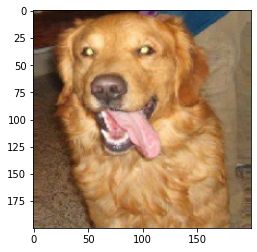

1.0


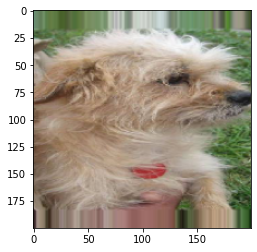

1.0


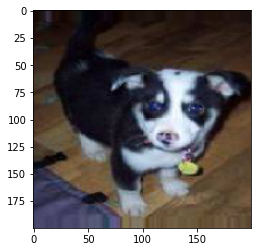

1.0


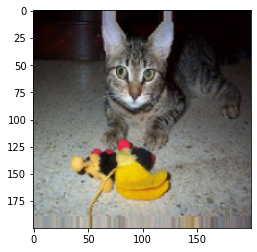

0.0


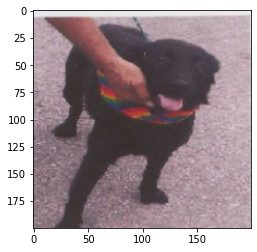

1.0


In [0]:
# Insert your code here to obtain a sample training images batch from the train directory generator
x,y = best_train_generator.next()

for i in range(5):
    # Insert your code here to visualize the training images
    image = x[i]
    visualize_image(image)
    
    
    # Insert your code here to print corresponding training label: Cat / Dog
    label = y[i]
    print (label)

    

# Build Model

---
Now build the model as per the best dropout probability value determined earlier. Summarize the model architecture.

---

**2 Points**

---




In [0]:
# Insert your code here to build the CNN model as per the best dropout probability value determined earlier
model= build_cnn_model(0.5)

# Insert your code here to print the model summary
print(model.summary())


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 23, 23, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 67712)            

# Training the Model

---
Train the model built with best hyperparameter settings. Generate a **Plot** of Epochs Vs. training and validation accuracy. Also generate a similar plot for training and validation loss. Discuss your **inferences** from the plot.


---

**7 Points**


---



Epoch 1/5
32/31 [==============================] - 176s 6s/step - loss: 0.6936 - accuracy: 0.5090 - val_loss: 0.6910 - val_accuracy: 0.4979
Epoch 2/5
32/31 [==============================] - 176s 5s/step - loss: 0.6925 - accuracy: 0.5055 - val_loss: 0.6925 - val_accuracy: 0.5021
Epoch 3/5
32/31 [==============================] - 175s 5s/step - loss: 0.6902 - accuracy: 0.5325 - val_loss: 0.6880 - val_accuracy: 0.5063
Epoch 4/5
32/31 [==============================] - 176s 6s/step - loss: 0.6875 - accuracy: 0.5495 - val_loss: 0.6841 - val_accuracy: 0.5916
Epoch 5/5
32/31 [==============================] - 175s 5s/step - loss: 0.6871 - accuracy: 0.5400 - val_loss: 0.6841 - val_accuracy: 0.5137


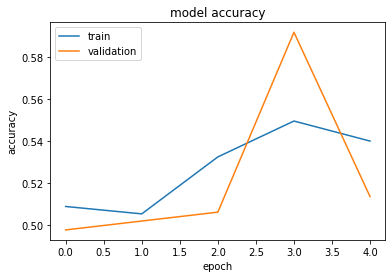

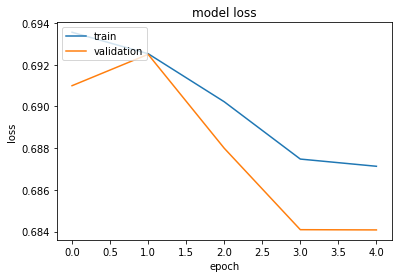

In [0]:
# Insert your code here to train the CNN model with best hyperparameter settings using training set and validate using the validation set (1 Point)
hist=model.fit_generator(best_train_generator,steps_per_epoch =2000/64,epochs = 5,
        validation_data = best_validation_generator,validation_steps = 953/64)
        

# Insert your code here to obtain the lists: epochs, training accuracy, validation accuracy, training loss, validation loss (2 Points)
hist.history.keys()



# Insert your code here to plot Epochs Vs. training and validation accuracy (2 Points)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



# Insert your code here to plot Epochs Vs. training and validation loss (2 Points)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()




From the plot of accuracy we can see that the validation accuracy is decreasing after reaching 3 epochs.May be the model is overfitted.

From the plot of loss, we can see that the model has comparable performance on both train and validation datasets.The loss can further be decreased by increasing the number of epochs. 


# Prediction

---
Fetch a sample test batch and determine the model's predictions on this batch of test images. Generate a confusion matrix and comment on the prediction statistics.



---

**Note**: Predictions would return the probability of the image belonging to class 1 (Dog). If this value is more than 0.5, assign class 1 (Dog) as the prediction. Else, assign class 0(Cat) as the prediction.

---
**2 Points**

---





In [0]:
import pylab as pl
# Insert your code here to obtain a sample test images batch from the test directory generator
test_generator=get_generator(test_dir_path, 64)

# Insert your code here to get the model's prediction probabilities
Y_pred = model.predict_generator(test_generator,50/64)

# Insert your code here to assign class label based on prediction probabilities
#if y_pred.any() >= 0.5:
#    prediction = 'dogs'
#else:
#    prediction = 'cats'
y_pred = np.argmax(Y_pred, axis=1)
# Insert your code here to print the confusion matrix.
print('Confusion Matrix')
print(confusion_matrix( test_generator.classes,y_pred))
#cm = confusion_matrix(test_generator.classes, y_pred)
#pl.matshow(cm)
#pl.title('Confusion matrix of the classifier')
#pl.colorbar()
#pl.show()



Found 50 images belonging to 2 classes.
Confusion Matrix
[[25  0]
 [25  0]]


Discuss the **inferences** you obtained from the confusion matrix.


---

**2 Points**


---



We can observe that our model predicts dogs and cats correctly with 50 % accuracy.Our model correctly classifies all the cats. But it classified all the dog instances as cat.